# Advanced Workflows

Although it would be possible to write analysis scripts using just Nipype [Interfaces](basic_interfaces.ipynb), and this may provide some advantages over directly making command-line calls, the main benefits of Nipype will come by creating workflows.

A workflow controls the setup and the execution of individual interfaces. Let's assume you want to run multiple interfaces in a specific order, where some have to wait for others to finish while others can be executed in parallel. The nice thing about a nipype workflow is, that the workflow  will take care of input and output of each interface and arrange the execution of each interface in the most efficient way.

A workflow therefore consists of multiple [Nodes](basic_nodes.ipynb), each representing a specific [Interface](basic_interfaces.ipynb) and directed connection between those nodes. Those connections specify which output of which node should be used as an input for another node. To better understand why this is so great, let's look at an example.

#### Let's import the code from the previous tutorial

In [1]:
%pylab inline
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')
def plot_nii(in_file):
    import nibabel as nb
    nii =nb.load(in_file)
    nii.orthoview()

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import re
import nibabel as nb
from scipy.io import savemat

from nipype.interfaces.base import (
    BaseInterfaceInputSpec, BaseInterface,
    CommandLine, CommandLineInputSpec,
    File, TraitedSpec, traits
)


class TransformInfoInputSpec(CommandLineInputSpec):
    in_file = File(exists=True, mandatory=True, argstr='%s', position=0, desc='the input transform file')
    
class TransformInfoOutputSpec(TraitedSpec):
    translation = traits.List(traits.Float, desc='the translation component of the input transform')

class TransformInfo(CommandLine):
    _cmd = 'antsTransformInfo'
    input_spec = TransformInfoInputSpec
    output_spec = TransformInfoOutputSpec
            
    def _run_interface(self, runtime):
        import re
        
        # Run the command line as a natural CommandLine interface
        runtime = super(TransformInfo, self)._run_interface(runtime)

        # Search transform in the standard output
        expr_tra = re.compile('Translation:\s+\[(?P<translation>[0-9\.-]+,\s[0-9\.-]+,\s[0-9\.-]+)\]')
        trans = [float(v) for v in expr_tra.search(runtime.stdout).group('translation').split(', ')]
        
        # Save it for later use in _list_outputs
        setattr(self, '_result', trans)
        
        # Good to go
        return runtime
    
    def _list_outputs(self):
        # Get the attribute saved during _run_interface
        return {'translation': getattr(self, '_result')}
    

class TranslateImageInputSpec(BaseInterfaceInputSpec):
    in_file = File(exists=True, mandatory=True, desc='the input image')
    out_file = File(mandatory=True, desc='the output image') # Do not set exists=True !!
    translation = traits.List([100.0, 0.0, 0.0], traits.Float, usedefault=True,
                              desc='the translation component of the input transform')
    
class TranslateImageOutputSpec(TraitedSpec):
    out_file = File(desc='the output image')
    
class TranslateImage(BaseInterface):
    input_spec = TranslateImageInputSpec
    output_spec = TranslateImageOutputSpec
    
    def _run_interface(self, runtime):
        # Call our python code here:
        translate_image(
            self.inputs.in_file,
            self.inputs.translation,
            self.inputs.out_file
        )
        # And we are done
        return runtime

    def _list_outputs(self):
        return {'out_file': os.path.abspath(self.inputs.out_file)}
    
    
class CustomBETInputSpec(CommandLineInputSpec):
    in_file = File(exists=True, mandatory=True, argstr='%s', position=0, desc='the input image')
    out_file = File(mandatory=True, argstr='%s', position=1, desc='the output image') # Do not set exists=True !!
    
class CustomBETOutputSpec(TraitedSpec):
    out_file = File(desc='the output image')
    
class CustomBET(CommandLine):
    _cmd = 'bet'
    input_spec = CustomBETInputSpec
    output_spec = CustomBETOutputSpec
    
    def _list_outputs(self):
        # Get the attribute saved during _run_interface
        return {'out_file': os.path.abspath(self.inputs.out_file)}


class BrainVolumeMATLABInputSpec(BaseInterfaceInputSpec):
    in_file = File(exists=True, mandatory=True)
    script_file = File(exists=True, mandatory=True)
    
class BrainVolumeMATLABOutputSpec(TraitedSpec):
    volume = traits.Int(desc='brain volume')
    out_file = File(desc='text file containing the brain volume value')

class BrainVolumeMATLAB(BaseInterface):
    input_spec = BrainVolumeMATLABInputSpec
    output_spec = BrainVolumeMATLABOutputSpec
    
    def _run_interface(self, runtime): 
        # Save the image in matlab format as tmp_image.mat
        tmp_image = 'tmp_image'
        data = nb.load(self.inputs.in_file).get_data()
        savemat(tmp_image, {b'data': data}, do_compression=False)
        
        # Load script
        with open(self.inputs.script_file) as script_file:
            script_content = script_file.read()
        
        # Replace the input_image.mat file for the actual input of this interface
        with open('newscript.m', 'w') as script_file:
            script_file.write(script_content.replace('input_image.mat', 'tmp_image.mat'))

        # Run a matlab command
        mlab = CommandLine('octave', args='newscript.m', terminal_output='file')
        result = mlab.run()
        
        expr_tra = re.compile('total\ =\s+(?P<total>[0-9]+)')
        volume = int(expr_tra.search(result.runtime.stdout).groupdict()['total'])
        setattr(self, '_result', volume)
        
        out_fname = os.path.abspath('volume.txt')
        setattr(self, '_out_file', out_fname)
        # Write out file
        with open(out_fname, 'w') as f:
            f.write('%d' % volume)
        
        return result.runtime

    def _list_outputs(self):
        outputs = self._outputs().get()
        outputs['volume'] = getattr(self, '_result')
        outputs['out_file'] = getattr(self, '_out_file')
        return outputs
    
    
def translate_image(img, translation, out_file):
    import nibabel as nb
    import numpy as np
    from scipy.ndimage.interpolation import affine_transform
    
    nii = nb.load(img)
    data = nii.get_data()
    
    matrix = np.eye(3)
    trans = (np.array(translation) / nii.header.get_zooms()[:3]) * np.array([1.0, -1.0, -1.0])
    
    newdata = affine_transform(data, matrix=matrix, offset=trans)
    
    nb.Nifti1Image(newdata, nii.affine, nii.header).to_filename(out_file)
    
    print('Translated file now is here: %s' % out_file)
    

# My first ``Workflow``

Now that we have written our precious interfaces (``TransformInfo``, ``TranslateImage``, ``CustomBET``, and ``BrainVolumeMATLAB``), let's put them together to achieve our true objective: measuring the volume of the brain after applying a translation read off an ITK transform file.

In order to insert interfaces into a ``Workflow``, we need to decorate them with the ``Node`` class that makes them homogeneous to the eyes of the workflow. Let's import them:

In [3]:
from nipype import Node, Workflow

Decorating the interfaces with ``Node`` is straightforward. The only *additional issue* we need to remember is that all ``Node``s must have a **unique name** (no dots or dashes allowed):

In [4]:
node_bet = Node(CustomBET(out_file='brain.nii.gz'), name='custom_bet')
node_info = Node(TransformInfo(), name='read_tfm')
node_tfm = Node(TranslateImage(out_file='transformed.nii.gz'), name='translation')
node_vol = Node(BrainVolumeMATLAB(), name='get_volume')

We want these interfaces to work coordinated together. Defining how they will interconnect each other is our task when designing a processing flow. For this very simple example:
  1. We will execute skull-stripping on our input T1-weighted image
  2. We will apply a transform from a prescribed file to the data
  3. Finally, we will count how many pixels of this brain are still within the field of view of the image

This processing flow can be implemented by making the appropriate *connections* between the Nodes. We first create the workflow object, an empty placeholder for the nodes we connect.

In [5]:
# Initiation of a workflow
wf = Workflow(name="my_first_workflow")

The Workflow object has a method called ``connect`` that is going to do most of the work here. This routine also checks if inputs and outputs are actually provided by the nodes that are being connected.

There are two different ways to call ``connect``:

    connect(source, "source_output", dest, "dest_input")

    connect([(source, dest, [("source_output1", "dest_input1"),
                             ("source_output2", "dest_input2")
                             ])
             ])

With the first approach you can establish one connection at a time. With the second you can establish multiple connects between two nodes at once. In either case, you're providing it with four pieces of information to define the connection:

- The source node object
- The name of the output field from the source node
- The destination node object
- The name of the input field from the destination node

We'll illustrate each method in the following cell:

In [6]:
# First the "simple", but more restricted method
wf.connect(node_bet, "out_file", node_tfm, "in_file")

# Now the more complicated method
wf.connect([
    (node_info, node_tfm, [("translation", "translation")]),
    (node_tfm, node_vol, [("out_file", "in_file")])
])

Now the workflow is complete!

Above, we mentioned that the workflow can be thought of as a directed acyclic graph. In fact, that's literally how it's represented behind the scenes, and we can use that to explore the workflow visually:

170328-12:17:48,315 workflow INFO:
	 Generated workflow graph: /home/jovyan/work/graph.dot.png (graph2use=hierarchical, simple_form=True).


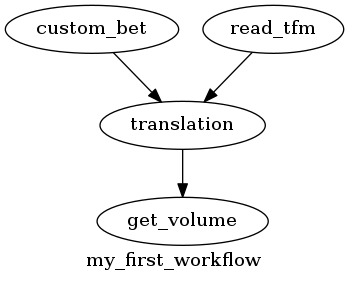

In [7]:
Image(filename=wf.write_graph())

This representation makes the dependency structure of the workflow obvious. (By the way, the names of the nodes in this graph are the names we gave our Node objects above, so pick something meaningful for those!)

Certain graph types also allow you to further inspect the individual connections between the nodes. For example:

170328-12:17:48,505 workflow INFO:
	 Generated workflow graph: /home/jovyan/work/graph_detailed.dot.png (graph2use=flat, simple_form=True).


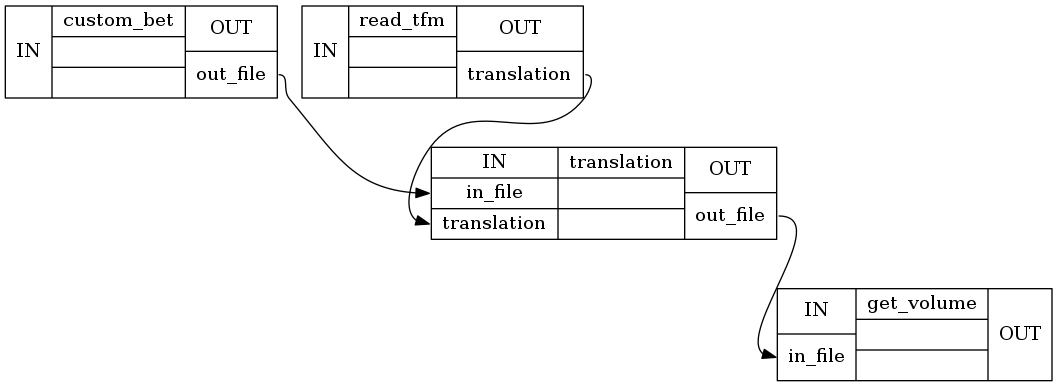

In [8]:
Image(filename=wf.write_graph(graph2use='flat'))

For more information on graph visualization, see Michael Notter's [Graph Visualization Tutorial](http://miykael.github.io/nipype-beginner-s-guide/visualizePipeline.html).

But let's come back to our example. At this point, all we've done is define the workflow. We haven't executed any code yet. Much like Interface objects, the Workflow object has a ``run`` method that we can call so that it executes. Let's do that and then examine the results.

In [9]:
# Specify the base directory for the working directory
wf.base_dir = "working_dir"

# Specify the workflow inputs:
wf.inputs.read_tfm.in_file = os.path.abspath('files/transform.tfm') # Note that the workflow will change the
                                                                    # working directory to ./working_dir/
wf.inputs.custom_bet.in_file = '/data/ds000114/sub-01/anat/sub-01_T1w.nii.gz'
wf.inputs.get_volume.script_file= os.path.abspath('files/brainvolume.m')

# Execute the workflow
wf.run()

170328-12:17:49,948 workflow INFO:
	 Workflow my_first_workflow settings: ['check', 'execution', 'logging']
170328-12:17:49,975 workflow INFO:
	 Running serially.
170328-12:17:49,980 workflow INFO:
	 Executing node custom_bet in dir: /home/jovyan/work/working_dir/my_first_workflow/custom_bet
170328-12:17:50,1 workflow INFO:
170328-12:17:50,15 workflow INFO:
	 Executing node read_tfm in dir: /home/jovyan/work/working_dir/my_first_workflow/read_tfm
170328-12:17:50,35 workflow INFO:
170328-12:17:50,58 workflow INFO:
	 Executing node translation in dir: /home/jovyan/work/working_dir/my_first_workflow/translation
170328-12:17:50,81 workflow INFO:
170328-12:17:50,91 workflow INFO:
	 Executing node get_volume in dir: /home/jovyan/work/working_dir/my_first_workflow/get_volume
170328-12:17:50,115 workflow INFO:


The specification of ``base_dir`` is very important (and is why we needed to use absolute paths above), because otherwise all the outputs would be saved somewhere in the temporary files. Unlike interfaces, which by default spit out results to the local directry, the Workflow engine executes things off in its own directory hierarchy.

In [10]:
!cat working_dir/my_first_workflow/get_volume/volume.txt

3329279

Perfect!

Let's also have a closer look at the working directory:

In [11]:
!tree working_dir -I '*js|*json|*html|*pklz|_report'

working_dir
├── my_first_workflow
│   ├── custom_bet
│   │   ├── brain.nii.gz
│   │   └── command.txt
│   ├── get_volume
│   │   └── volume.txt
│   ├── read_tfm
│   │   └── command.txt
│   └── translation
│       └── transformed.nii.gz
└── susanflow
    ├── graph.dot
    ├── graph.dot.png
    ├── list_extract
    ├── mask
    │   ├── command.txt
    │   └── sub-02_T1w_smooth_masked.nii.gz
    ├── skullstrip
    │   ├── command.txt
    │   └── sub-02_T1w_brain_mask.nii.gz
    └── susan_smooth
        ├── mask
        │   └── mapflow
        │       └── _mask0
        │           ├── command.txt
        │           └── sub-02_T1w_mask.nii.gz
        ├── meanfunc2
        │   └── mapflow
        │       └── _meanfunc20
        │           ├── command.txt
        │           └── sub-02_T1w_mask_mean.nii.gz
        ├── median
        │   └── mapflow
        │       └── _median0
        │           └── command.txt
        ├── merge
        └── smooth
            └── mapflow
                └

As you can see, the name of the working directory is the name we gave the workflow ``base_dir``. And the name of the folder within is the name of the workflow object ``my_first_workflow``. Each node of the workflow has its own subfolder in the ``my_first_workflow`` folder. And each of those subfolders contains the output of the node as well as some additional files.

## The #1 gotcha of nipype Workflows

The workflows are just DAGs (Directed Acyclic Graphs) that the runner ``Plugin`` takes in and uses to compose an ordered list of nodes for execution. As a matter of fact, running a workflow will return a graph object, as we find in the output of cell 8:

  ```
  Out[8]: <networkx.classes.digraph.DiGraph at 0x7f92284a3050>
  ```
  

The principal implication is that ``Workflow``s *don't have inputs and outputs*, you can just access them through the ``Node`` decoration.

In practical terms, this has one clear consequence: from the resulting object of the workflow execution you don't generally have access to the value of the outputs of the interfaces. This is particularly true for Plugins with asynchronous execution.

## The smoothing workflow

Let's create a more useful workflow: we'll need three nodes. We'll first smooth the input image with a gaussian kernel and FWHM=4mm, then find the brain mask using BET and finally apply the brain mask on the smoothed image.

In [12]:
# Import Node and Workflow object and FSL interface
from nipype import Node, Workflow
from nipype.interfaces import fsl

in_file = "/data/ds000114/sub-02/anat/sub-02_T1w.nii.gz"

# Smooth process
node_smooth = Node(fsl.IsotropicSmooth(in_file=in_file, fwhm=4), name="smooth")

# Skullstrip process
node_bet = Node(fsl.BET(in_file=in_file, frac=0.2, mask=True), name="skullstrip")

# Mask process
node_mask = Node(fsl.ApplyMask(), name="mask")

### Exercise

Please connect the nodes in a workflow, so that the resulting graph looks like:
![smoothflow](files/smoothflow.png)

In [13]:
# Initiation of a workflow
wf = Workflow(name="smoothflow")
wf.base_dir = 'smoothflow_example'

# Connect nodes here


Now we can check the workflow graph and run it

170328-12:17:58,585 workflow INFO:
	 Generated workflow graph: smoothflow_example/smoothflow/workflow_graph.dot.png (graph2use=hierarchical, simple_form=True).


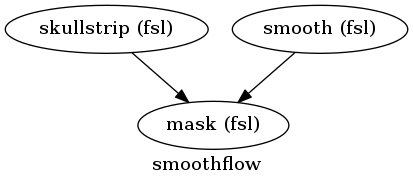

In [14]:
wf.write_graph("workflow_graph.dot")
from IPython.display import Image
Image(filename="smoothflow_example/smoothflow/workflow_graph.dot.png")

In [15]:
%%timeit
wf.run()

170328-12:17:58,615 workflow INFO:
	 Workflow smoothflow settings: ['check', 'execution', 'logging']
170328-12:17:58,660 workflow INFO:
	 Running serially.
170328-12:17:58,665 workflow INFO:
	 Executing node skullstrip in dir: /home/jovyan/work/smoothflow_example/smoothflow/skullstrip
170328-12:17:58,707 workflow INFO:
	 Running: bet /data/ds000114/sub-02/anat/sub-02_T1w.nii.gz /home/jovyan/work/smoothflow_example/smoothflow/skullstrip/sub-02_T1w_brain.nii.gz -f 0.20 -m
170328-12:18:02,856 workflow INFO:
	 Executing node smooth in dir: /home/jovyan/work/smoothflow_example/smoothflow/smooth
170328-12:18:02,877 workflow INFO:
	 Running: fslmaths /data/ds000114/sub-02/anat/sub-02_T1w.nii.gz -s 1.69864 /home/jovyan/work/smoothflow_example/smoothflow/smooth/sub-02_T1w_smooth.nii.gz
170328-12:18:09,73 workflow INFO:
	 Executing node mask in dir: /home/jovyan/work/smoothflow_example/smoothflow/mask
170328-12:18:09,93 workflow INFO:
	 Running: fslmaths /home/jovyan/work/smoothflow_example/smoo

Results are cached (we'll get back to this):

In [16]:
%%timeit
wf.run()

170328-12:18:11,660 workflow INFO:
	 Workflow smoothflow settings: ['check', 'execution', 'logging']
170328-12:18:11,690 workflow INFO:
	 Running serially.
170328-12:18:11,696 workflow INFO:
	 Executing node smooth in dir: /home/jovyan/work/smoothflow_example/smoothflow/smooth
170328-12:18:11,716 workflow INFO:
170328-12:18:11,735 workflow INFO:
	 Executing node skullstrip in dir: /home/jovyan/work/smoothflow_example/smoothflow/skullstrip
170328-12:18:11,752 workflow INFO:
170328-12:18:11,774 workflow INFO:
	 Executing node mask in dir: /home/jovyan/work/smoothflow_example/smoothflow/mask
170328-12:18:11,786 workflow INFO:
170328-12:18:11,797 workflow INFO:
	 Workflow smoothflow settings: ['check', 'execution', 'logging']
170328-12:18:11,828 workflow INFO:
	 Running serially.
170328-12:18:11,832 workflow INFO:
	 Executing node smooth in dir: /home/jovyan/work/smoothflow_example/smoothflow/smooth
170328-12:18:11,847 workflow INFO:
170328-12:18:11,853 workflow INFO:
	 Executing node skul

... in the base_dir (``smoothflow_example``):

In [17]:
!tree smoothflow_example -I '*js|*json|*html|*pklz|_report'

smoothflow_example
└── smoothflow
    ├── mask
    │   ├── command.txt
    │   └── sub-02_T1w_smooth_masked.nii.gz
    ├── skullstrip
    │   ├── command.txt
    │   └── sub-02_T1w_brain_mask.nii.gz
    ├── smooth
    │   ├── command.txt
    │   └── sub-02_T1w_smooth.nii.gz
    ├── workflow_graph.dot
    └── workflow_graph.dot.png

4 directories, 8 files


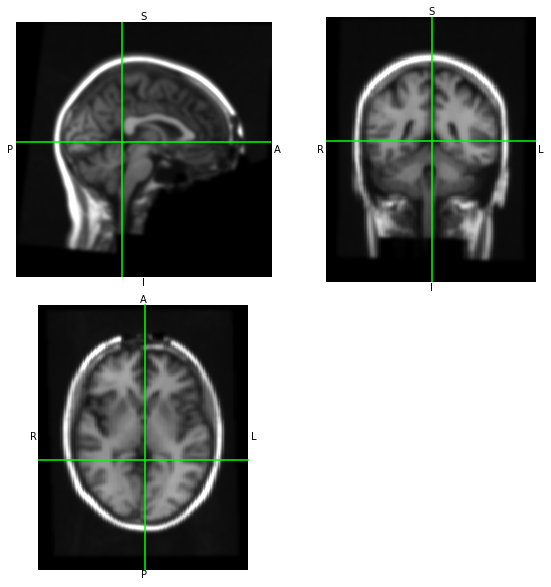

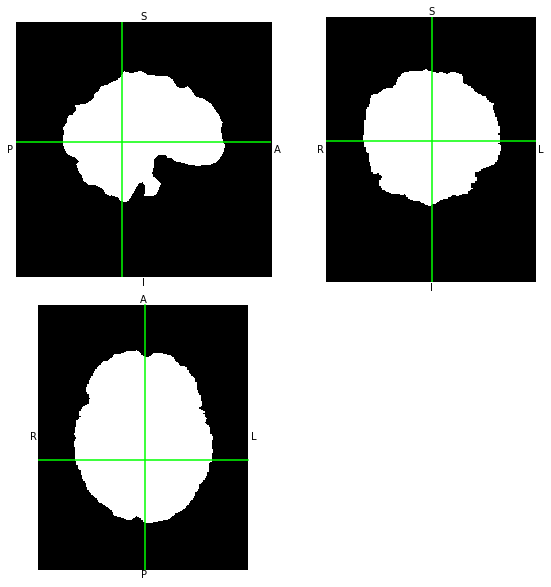

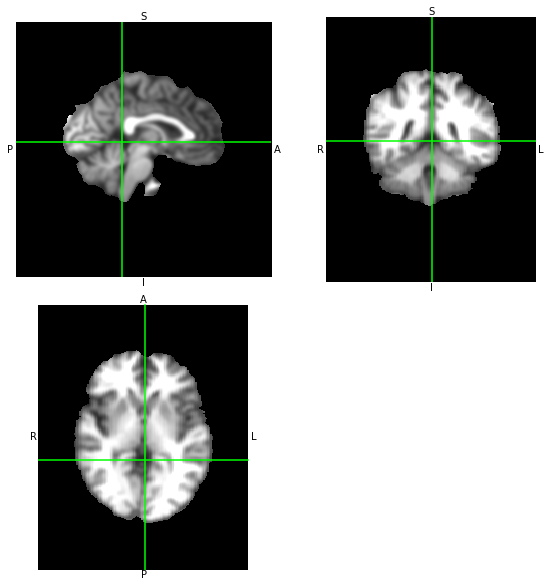

In [18]:
plot_nii('./smoothflow_example/smoothflow/smooth/sub-02_T1w_smooth.nii.gz')
plot_nii('./smoothflow_example/smoothflow/skullstrip/sub-02_T1w_brain_mask.nii.gz')
plot_nii('./smoothflow_example/smoothflow/mask/sub-02_T1w_smooth_masked.nii.gz')

# Pre-defined nipype workflows

Nipype comes with [a series of workflows ready to use](http://nipype.readthedocs.io/en/latest/documentation.html) out-of-the-box. Let's pick a simple one:

170328-12:18:39,730 workflow INFO:
	 Generated workflow graph: /home/jovyan/work/denoise_workflow/Denoise/graph_detailed.dot.png (graph2use=flat, simple_form=True).


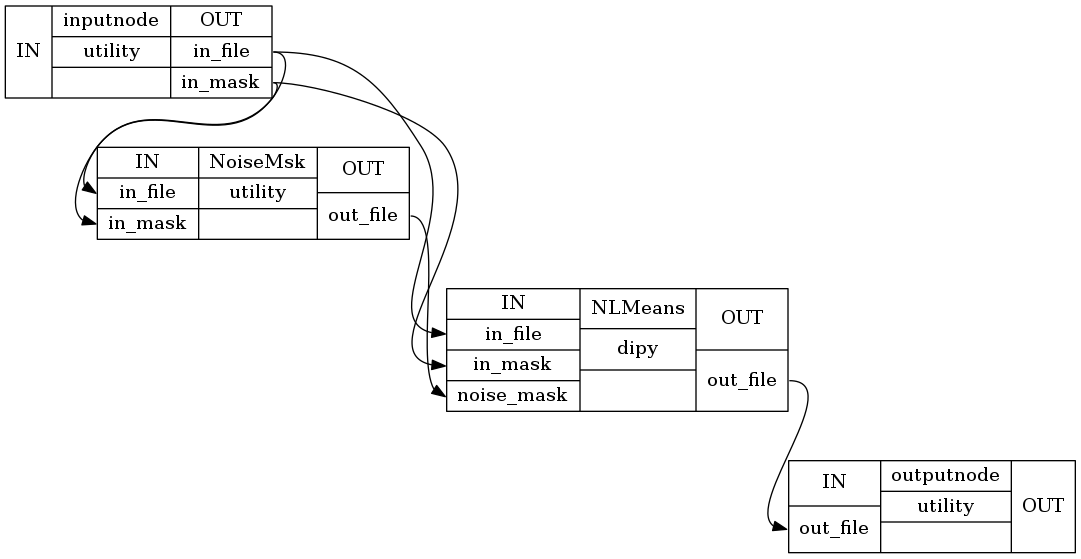

In [19]:
from os import path as op
from nipype.workflows.dmri.dipy.denoise import nlmeans_pipeline
denoise = nlmeans_pipeline()
denoise.base_dir = 'denoise_workflow'
Image(filename=denoise.write_graph(graph2use="flat"))

The implementation can be found [here](https://github.com/nipy/nipype/blob/d38748132cb02ca6bad3150826fc5b37e92ae3ad/nipype/workflows/dmri/dipy/denoise.py#L12). For development purposes, we can inspect the inputs of the workflow. All inputs of the interfaces within a workflow which are not connected to some output are considered potential inputs.

In [20]:
denoise._get_inputs()


NLMeans = 
block_radius = 5
noise_model = rician
patch_radius = 1
signal_mask = <undefined>
snr = <undefined>

NoiseMsk = 
function_str = def bg_mask(in_file, in_mask, out_file=None):
    """
    Rough mask of background from brain masks
    """
    import nibabel as nb
    import numpy as np
    from scipy.ndimage import binary_dilation
    import scipy.ndimage as nd
    import os.path as op
    from nipype.utils import NUMPY_MMAP

    if out_file is None:
        fname, ext = op.splitext(op.basename(in_file))
        if ext == ".gz":
            fname, ext2 = op.splitext(fname)
            ext = ext2 + ext
        out_file = op.abspath("%s_bgmask%s" % (fname, ext))

    im = nb.load(in_file, mmap=NUMPY_MMAP)
    hdr = im.header.copy()
    hdr.set_data_dtype(np.uint8)
    hdr.set_xyzt_units('mm')
    imdata = im.get_data()
    msk = nb.load(in_mask, mmap=NUMPY_MMAP).get_data()
    msk = 1 - binary_dilation(msk, structure=np.ones((20, 20, 20)))
    nb.Nifti1Image(msk.astype(np.uint8),

In the case of the outputs, every output can be connected several times. So all output fields are considered potential outputs for the workflow.

In [21]:
denoise._get_outputs()


NLMeans = 
out_file = None

NoiseMsk = 
out_file = None

inputnode = 
in_file = None
in_mask = None

outputnode = 
out_file = None


For clarity purposes, in Nipype we have the non-written standard of having two special interfaces called ``inputnode`` and ``outputnode`` to gather up usable inputs and outputs of workflows. They only buffer the values of inputs and outputs. So let's set them for our workflow:

In [22]:
denoise.inputs.inputnode.in_file = "/data/ds000114/sub-02/anat/sub-02_T1w.nii.gz"
denoise.inputs.inputnode.in_mask = op.abspath('./smoothflow_example/smoothflow/skullstrip/sub-02_T1w_brain_mask.nii.gz')
denoise.run()

170328-12:18:42,467 workflow INFO:
	 Workflow Denoise settings: ['check', 'execution', 'logging']
170328-12:18:42,480 workflow INFO:
	 Running serially.
170328-12:18:42,485 workflow INFO:
	 Executing node NoiseMsk in dir: /home/jovyan/work/denoise_workflow/Denoise/NoiseMsk
170328-12:19:45,408 workflow INFO:
	 Executing node NLMeans in dir: /home/jovyan/work/denoise_workflow/Denoise/NLMeans
170328-12:20:38,189 interface INFO:
	 Denoised image saved as /home/jovyan/work/denoise_workflow/Denoise/NLMeans/sub-02_T1w_denoise.nii.gz, estimated SNR=[5.4565535]


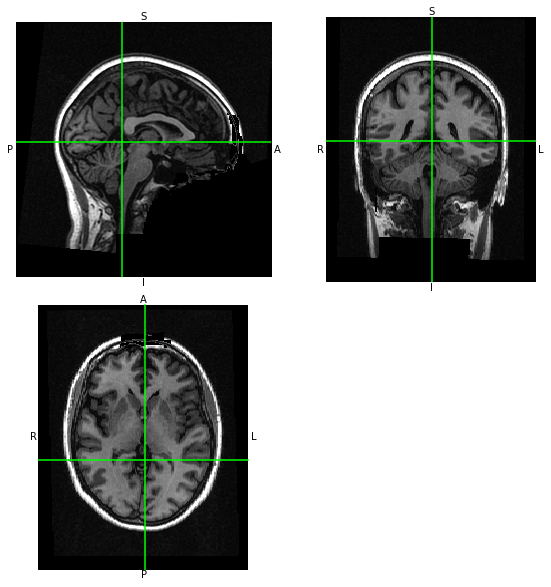

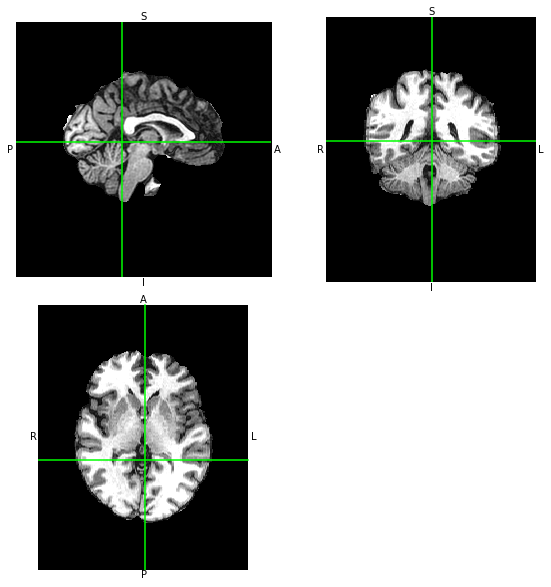

In [23]:
plot_nii("/data/ds000114/sub-02/anat/sub-02_T1w.nii.gz")
plot_nii("/home/jovyan/work/denoise_workflow/Denoise/NLMeans/sub-02_T1w_denoise.nii.gz")

## MRIQC Anatomical workflow
![some image](http://mriqc.readthedocs.io/en/latest//workflows-3.png)

## FSL-based workflow using SUSAN
When you start writing full-fledged analysis workflows, things can get quite complicated. Some aspects of neuroimaging analysis can be thought of as a coherent step at a level more abstract than the execution of a single command line binary. For instance, in the standard FEAT script in FSL, several calls are made in the process of using `susan` to perform nonlinear smoothing on an image. In Nipype, you can write **nested workflows**, where a sub-workflow can take the place of a Node in a given script.

Let's use the prepackaged `susan` workflow that ships with Nipype to replace our Gaussian filtering node and demonstrate how this works.

In [24]:
from nipype.workflows.fmri.fsl import create_susan_smooth

Calling this function will return a pre-written `Workflow` object:

In [25]:
susan = create_susan_smooth(separate_masks=False)

Let's display the graph to see what happens here.

170328-12:20:59,260 workflow INFO:
	 Generated workflow graph: /home/jovyan/work/graph.dot.png (graph2use=hierarchical, simple_form=True).


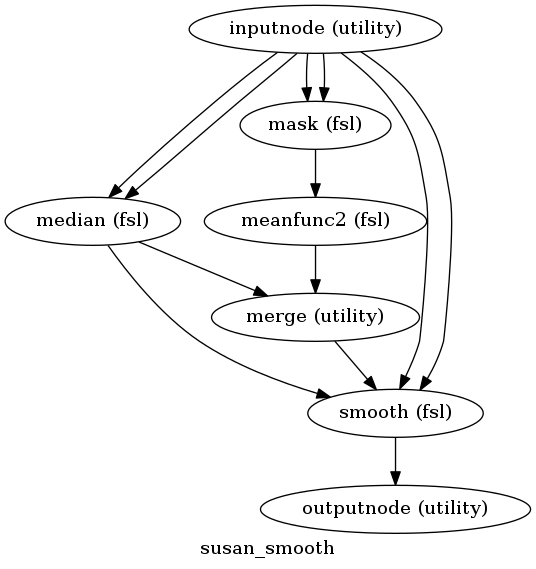

In [26]:
Image(filename=susan.write_graph())

We see that the workflow has an `inputnode` and an `outputnode`. While not strictly necessary, this is standard practice for workflows (especially those that are intended to be used as nested workflows in the context of a longer analysis graph) and makes it more clear how to connect inputs and outputs from this workflow.

Let's take a look at what those inputs and outputs are. Like Nodes, Workflows have `inputs` and `outputs` attributes that take a second sub-attribute corresponding to the specific node we want to make connections to.

In [27]:
print("Inputs:\n", susan.inputs.inputnode)
print("Outputs:\n", susan.outputs.outputnode)

Inputs:
 
fwhm = <undefined>
in_files = <undefined>
mask_file = <undefined>

Outputs:
 
smoothed_files = None



Note that `inputnode` and `outputnode` are just conventions, and the Workflow object exposes connections to all of its component nodes:

In [28]:
susan.inputs.median


args = <undefined>
environ = {'FSLOUTPUTTYPE': 'NIFTI_GZ'}
ignore_exception = False
op_string = -k %s -p 50
output_type = NIFTI_GZ
split_4d = <undefined>
terminal_output = stream

Let's see how we would write a new workflow that uses this nested smoothing step.

The susan workflow actually expects to receive and output a list of files (it's intended to be executed on each of several runs of fMRI data). We'll cover exactly how that works in later tutorials, but for the moment we need to add an additional ``Function`` node to deal with the fact that ``susan`` is outputting a list. We can use a simple `lambda` function to do this:

In [29]:
from nipype import Function
def _get_first(inlist):
    return inlist[0]

list_extract = Node(Function(input_names=["inlist"],
                             output_names=["out_file"],
                             function=_get_first),
                    name="list_extract")

Now let's create a new workflow ``susanflow`` that contains the ``susan`` workflow as a sub-node. To be sure, let's also recreate the ``skullstrip`` and the ``mask`` node from the examples above.

In [30]:
# Initiate workflow with name and base directory
wf2 = Workflow(name="susanflow", base_dir="working_dir")

# Create new skullstrip and mask nodes
skullstrip2 = Node(fsl.BET(in_file=in_file, mask=True, frac=0.25), name="skullstrip")
mask2 = Node(fsl.ApplyMask(), name="mask")

# Connect the nodes to each other and to the susan workflow
wf2.connect([(skullstrip2, mask2, [("mask_file", "mask_file")]),
             (skullstrip2, susan, [("mask_file", "inputnode.mask_file")]),
             (susan, list_extract, [("outputnode.smoothed_files",
                                     "inlist")]),
             (list_extract, mask2, [("out_file", "in_file")])
             ])

# Specify the remaining input variables for the susan workflow
susan.inputs.inputnode.in_files = op.abspath("data/ds000114/sub-02/anat/sub-02_T1w.nii.gz")
susan.inputs.inputnode.fwhm = 4

First, let's see what this new processing graph looks like.

170328-12:21:21,539 workflow INFO:
	 Generated workflow graph: working_dir/susanflow/graph.dot.png (graph2use=colored, simple_form=True).


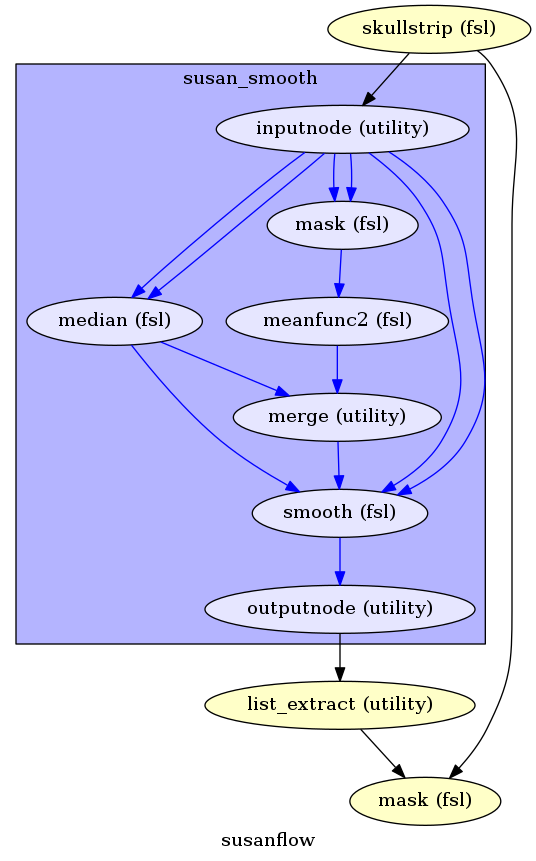

In [31]:
Image(filename=wf2.write_graph(graph2use='colored'))

We can see how there is a nested smoothing workflow (blue) in the place of our previous `smooth` node. This provides a very detailed view, but what if you just wanted to give a higher-level summary of the processing steps? After all, that is the purpose of encapsulating smaller streams in a nested workflow. That, fortunately, is an option when writing out the graph:

170328-12:21:29,126 workflow INFO:
	 Generated workflow graph: /home/jovyan/work/full_susanflow_toplevel_detailed.dot.png (graph2use=orig, simple_form=True).


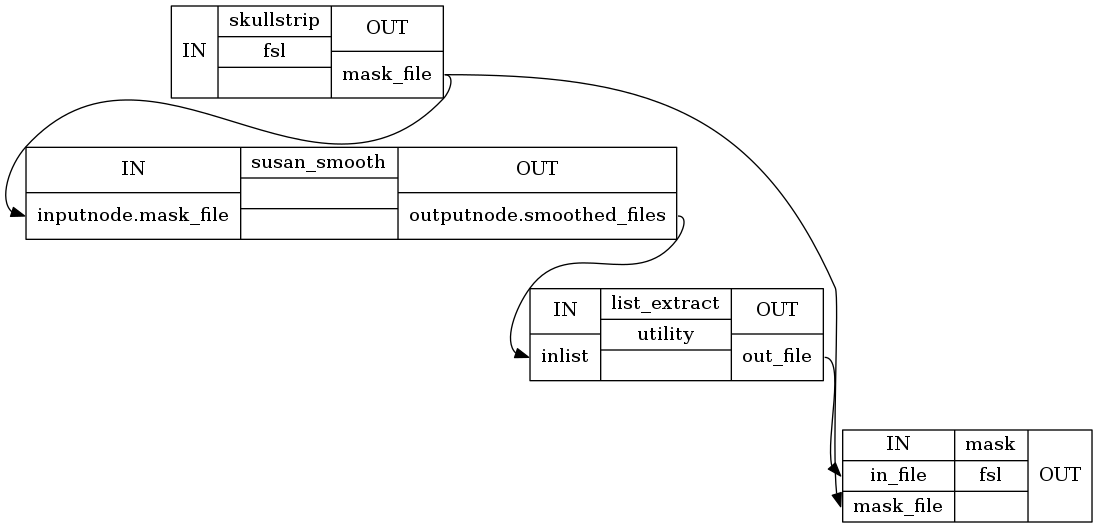

In [32]:
Image(filename=wf2.write_graph(dotfilename='./full_susanflow_toplevel.dot', graph2use='orig'))

That's much more managable. Now let's execute the workflow

In [33]:
wf2.run()

170328-12:21:30,922 workflow INFO:
	 Workflow susanflow settings: ['check', 'execution', 'logging']
170328-12:21:30,961 workflow INFO:
	 Running serially.
170328-12:21:30,965 workflow INFO:
	 Executing node skullstrip in dir: /home/jovyan/work/working_dir/susanflow/skullstrip
170328-12:21:30,988 workflow INFO:
170328-12:21:31,11 workflow INFO:
	 Executing node mask in dir: /home/jovyan/work/working_dir/susanflow/susan_smooth/mask
170328-12:21:31,69 workflow INFO:
	 Executing node meanfunc2 in dir: /home/jovyan/work/working_dir/susanflow/susan_smooth/meanfunc2
170328-12:21:31,113 workflow INFO:
	 Executing node median in dir: /home/jovyan/work/working_dir/susanflow/susan_smooth/median
170328-12:21:31,151 workflow INFO:
	 Executing node merge in dir: /home/jovyan/work/working_dir/susanflow/susan_smooth/merge
170328-12:21:31,181 workflow INFO:
170328-12:21:31,207 workflow INFO:
	 Executing node smooth in dir: /home/jovyan/work/working_dir/susanflow/susan_smooth/smooth
170328-12:21:31,255 

As a final step, let's look at the input and the output. It's exactly what we wanted.

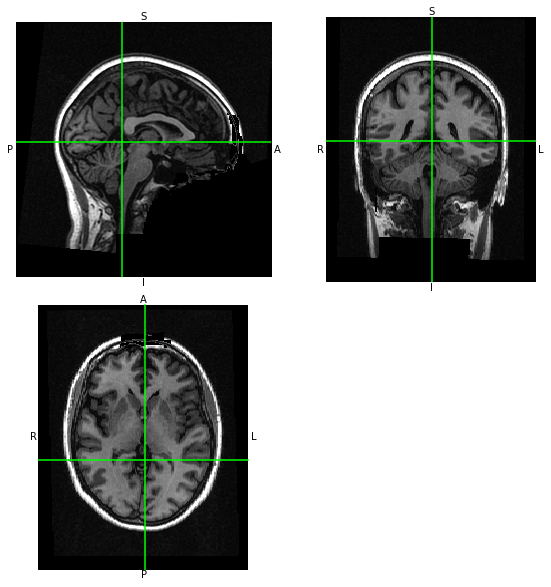

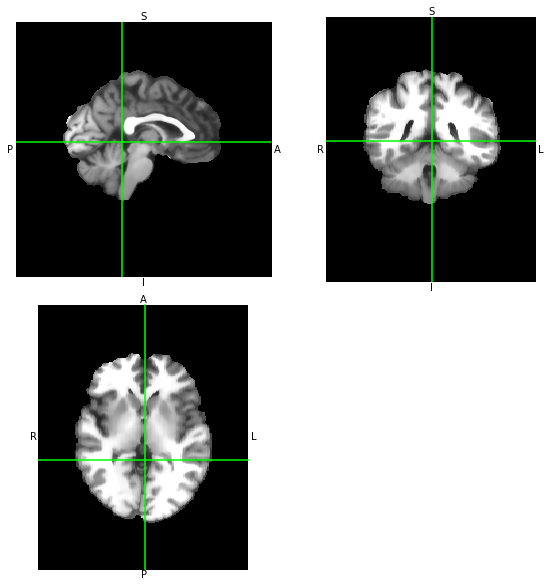

In [34]:
plot_nii("./data/ds000114/sub-02/anat/sub-02_T1w.nii.gz")
plot_nii("working_dir/susanflow/mask/sub-02_T1w_smooth_masked.nii.gz")

# So, why are workflows so great?

So far, we've seen that you can build up rather complex analysis workflows. But at the moment, it's not been made clear why this is worth the extra trouble from writing a simple procedural script. To demonstrate the first added benefit of the Nipype, let's just rerun the ``susanflow`` workflow from above and measure the execution times.

In [35]:
%%timeit
wf2.run()

170328-12:21:40,845 workflow INFO:
	 Workflow susanflow settings: ['check', 'execution', 'logging']
170328-12:21:40,877 workflow INFO:
	 Running serially.
170328-12:21:40,890 workflow INFO:
	 Executing node skullstrip in dir: /home/jovyan/work/working_dir/susanflow/skullstrip
170328-12:21:40,921 workflow INFO:
170328-12:21:40,942 workflow INFO:
	 Executing node mask in dir: /home/jovyan/work/working_dir/susanflow/susan_smooth/mask
170328-12:21:40,995 workflow INFO:
	 Executing node meanfunc2 in dir: /home/jovyan/work/working_dir/susanflow/susan_smooth/meanfunc2
170328-12:21:41,28 workflow INFO:
	 Executing node median in dir: /home/jovyan/work/working_dir/susanflow/susan_smooth/median
170328-12:21:41,72 workflow INFO:
	 Executing node merge in dir: /home/jovyan/work/working_dir/susanflow/susan_smooth/merge
170328-12:21:41,92 workflow INFO:
170328-12:21:41,117 workflow INFO:
	 Executing node smooth in dir: /home/jovyan/work/working_dir/susanflow/susan_smooth/smooth
170328-12:21:41,183 w

That happened quickly! Workflows (actually this is handled by the Node code) are smart, and know if their inputs have changed from the last time they are run. If they have not, they don't recompute; they just turn around and pass out the resulting files from the previous run. This is done on a node-by-node basis, also.

Let's go back to the first workflow example. What happened if we just tweak one thing:

In [36]:
wf.inputs.smooth.fwhm = 1
wf.run()

170328-12:21:45,590 workflow INFO:
	 Workflow smoothflow settings: ['check', 'execution', 'logging']
170328-12:21:45,611 workflow INFO:
	 Running serially.
170328-12:21:45,618 workflow INFO:
	 Executing node smooth in dir: /home/jovyan/work/smoothflow_example/smoothflow/smooth
170328-12:21:45,687 workflow INFO:
	 Running: fslmaths /data/ds000114/sub-02/anat/sub-02_T1w.nii.gz -s 0.42466 /home/jovyan/work/smoothflow_example/smoothflow/smooth/sub-02_T1w_smooth.nii.gz
170328-12:21:49,849 workflow INFO:
	 Executing node skullstrip in dir: /home/jovyan/work/smoothflow_example/smoothflow/skullstrip
170328-12:21:49,863 workflow INFO:
170328-12:21:49,878 workflow INFO:
	 Executing node mask in dir: /home/jovyan/work/smoothflow_example/smoothflow/mask
170328-12:21:49,948 workflow INFO:
	 Running: fslmaths /home/jovyan/work/smoothflow_example/smoothflow/smooth/sub-02_T1w_smooth.nii.gz -mas /home/jovyan/work/smoothflow_example/smoothflow/skullstrip/sub-02_T1w_brain_mask.nii.gz /home/jovyan/work/sm

By changing an input value of the ``smooth`` node, this node will be re-executed. This triggers a cascade such that any file depending on the ``smooth`` node (in this case, the ``mask`` node, also recompute). However, the ``skullstrip`` node hasn't changed since the first time it ran, so it just coughed up its original files.

That's one of the main benefit of using Workflows: **efficient recomputing**. 

Another benefits of Workflows is parallel execution, which is covered under [Plugins and Distributed Computing](./basic_plugins.ipynb). With Nipype it is very easy to up a workflow to an extremely parallel cluster computing environment.

In this case, that just means that the `skullstrip` and `smooth` Nodes execute together, but when you scale up to Workflows with many subjects and many runs per subject, each can run together, such that (in the case of unlimited computing resources), you could process 50 subjects with 10 runs of functional data in essentially the time it would take to process a single run.

To emphasize the contribution of Nipype here, you can write and test your workflow on one subject computing on your local CPU, where it is easier to debug. Then, with the change of a single function parameter, you can scale your processing up to a 1000+ node SGE cluster.